# Erweiterte Komorbiditäts-Netzwerk-Visualisierung
#### Ausfügung des Notebooks über Kernel-Restart; Bei weniger als 1000 Patienten nicht Empfohlen!; Synthea nicht deterministisch andere Ergebisse der Analysen
## NetworkX Integration & Interaktive Graph-Analyse

**Zweck:** Erstellung publikationsreifer Netzwerk-Visualisierungen und interaktiver Analysen

**Was macht dieses Notebook?**
- **NetworkX Export**: Übertragung des Neo4j-Graphen in NetworkX für erweiterte Analysen
- **Force-directed Layout**: Automatische Anordnung der Knoten basierend auf ihren Verbindungen
- **Interaktive Visualisierungen**: Plotly-basierte Graphen zum Erkunden der Daten
- **Subgraph-Analyse**: Detailanalyse spezifischer Krankheitscluster (z.B. Metabolisches Syndrom)
- **Netzwerk-Metriken**: Gradverteilung, kürzeste Pfade zwischen Erkrankungen

**Warum ist das nützlich?** Diese Visualisierungen helfen, komplexe Zusammenhänge zwischen Erkrankungen zu verstehen und Muster zu erkennen, die in reinen Zahlen schwer zu sehen sind.

**Datensatz:** Synthetische Patientendaten (Anzahl variiert je nach Generierung)

**Datum:** November 17, 2025


## Setup: Bibliotheken und Verbindung

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Stil festlegen
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# Verbindungseinstellungen
NEO4J_URI = "bolt://neo4j-synthea:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "synthea123"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

print("✅ Verbindung zu Neo4j hergestellt")


✅ Verbindung zu Neo4j hergestellt


## Schritt 1: Neo4j-Graph nach NetworkX exportieren

Wir erstellen einen NetworkX-Graphen mit:
- **Knoten**: ChronicDisease (chronische Erkrankungen) mit Attributen (Prävalenz, PageRank, Betweenness, Community-ID)
- **Kanten**: CO_OCCURS_WITH (tritt gemeinsam auf) mit Gewicht (cooccurrenceCount)

NetworkX ist eine Python-Bibliothek für Netzwerkanalyse und bietet viele zusätzliche Visualisierungs- und Analysemöglichkeiten.

In [2]:
# Lade Knoten (verwende elementId() statt veraltetem id())
nodes_query = """
MATCH (c:ChronicDisease)
RETURN elementId(c) as id,
       c.description as name,
       c.prevalence as prevalence,
       coalesce(c.pageRank, 0) as pageRank,
       coalesce(c.betweenness, 0) as betweenness,
       coalesce(c.communityId, -1) as communityId
"""

nodes_df = run_query(nodes_query)

# Lade Kanten (verwende elementId() statt veraltetem id())
edges_query = """
MATCH (c1:ChronicDisease)-[r:CO_OCCURS_WITH]->(c2:ChronicDisease)
RETURN elementId(c1) as source,
       elementId(c2) as target,
       coalesce(r.cooccurrenceCount, r.weight) as weight
"""

edges_df = run_query(edges_query)

# Erstelle NetworkX Graph
G = nx.Graph()

# Füge Knoten hinzu
for _, row in nodes_df.iterrows():
    G.add_node(row['id'], 
              name=row['name'],
              prevalence=row['prevalence'],
              pageRank=row['pageRank'],
              betweenness=row['betweenness'],
              communityId=row['communityId'])

# Füge Kanten hinzu
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

print("\n" + "="*60)
print("NETWORKX GRAPH STATISTIKEN")
print("="*60)
print(f"Knoten (Erkrankungen):      {G.number_of_nodes():,}")
print(f"Kanten (Komorbiditäten):    {G.number_of_edges():,}")
print(f"Dichte:                     {nx.density(G):.4f}")
print(f"Zusammenhängend:            {'Ja' if nx.is_connected(G) else 'Nein'}")
if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    print(f"Zusammenhangskomponenten:   {len(components)}")
    print(f"Größte Komponente:          {len(max(components, key=len))} Knoten")
print("="*60)



NETWORKX GRAPH STATISTIKEN
Knoten (Erkrankungen):      178
Kanten (Komorbiditäten):    3,358
Dichte:                     0.2132
Zusammenhängend:            Nein
Zusammenhangskomponenten:   19
Größte Komponente:          160 Knoten


## Schritt 2: Gradverteilungs-Analyse

**Was ist der Grad (Degree)?** Die Anzahl der Verbindungen, die eine Erkrankung zu anderen Erkrankungen hat. Ein hoher Grad bedeutet, dass diese Erkrankung mit vielen anderen Erkrankungen gemeinsam auftritt.

**Warum ist das wichtig?** Erkrankungen mit hohem Grad sind "Hubs" im Netzwerk - sie treten häufig zusammen mit vielen anderen Erkrankungen auf und sollten in der Behandlung besondere Aufmerksamkeit erhalten.


TOP 10 ERKRANKUNGEN NACH GRAD (Anzahl Komorbiditäten)

157 Verbindungen - Gingivitis (disorder) (2318 Patienten)
144 Verbindungen - Gingival disease (disorder) (1331 Patienten)
141 Verbindungen - Anemia (disorder) (1023 Patienten)
140 Verbindungen - Body mass index 30+ - obesity (finding) (1319 Patienten)
128 Verbindungen - Essential hypertension (disorder) (638 Patienten)
115 Verbindungen - Ischemic heart disease (disorder) (472 Patienten)
115 Verbindungen - Abnormal findings diagnostic imaging heart+coronary circulat (473 Patienten)
109 Verbindungen - Loss of teeth (disorder) (373 Patienten)
108 Verbindungen - Metabolic syndrome X (disorder) (391 Patienten)
107 Verbindungen - Disorder of kidney due to diabetes mellitus (disorder) (273 Patienten)


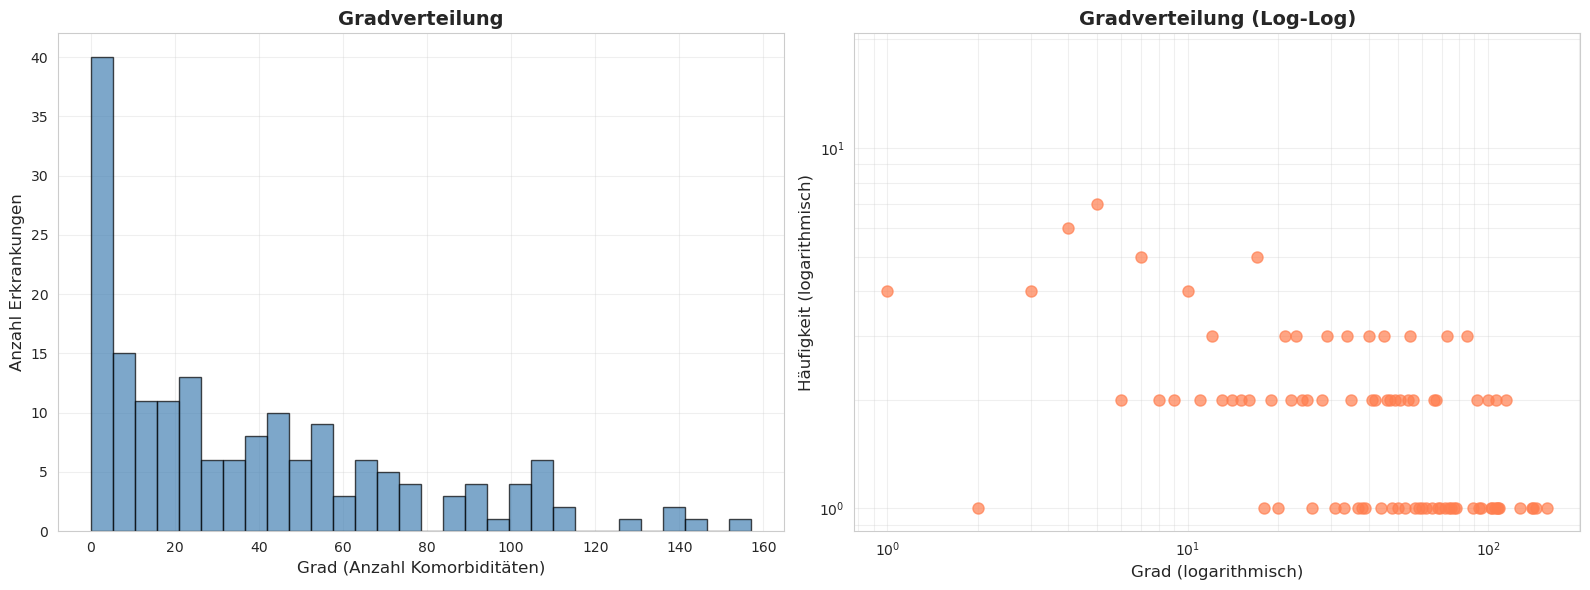


Statistiken:
   Durchschnittlicher Grad: 37.73
   Median Grad:             26
   Maximaler Grad:          157
   Minimaler Grad:          0


In [3]:
# Berechne Grade (Degree = Anzahl Verbindungen)
degrees = dict(G.degree())
degree_sequence = sorted(degrees.values(), reverse=True)

# Top 10 Knoten nach Grad
top_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTOP 10 ERKRANKUNGEN NACH GRAD (Anzahl Komorbiditäten)\n")
for node_id, degree in top_degrees:
    name = G.nodes[node_id]['name']
    prevalence = G.nodes[node_id]['prevalence']
    print(f"{degree:3d} Verbindungen - {name[:60]} ({prevalence} Patienten)")

# Gradverteilungs-Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogramm
ax1.hist(degree_sequence, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Grad (Anzahl Komorbiditäten)', fontsize=12)
ax1.set_ylabel('Anzahl Erkrankungen', fontsize=12)
ax1.set_title('Gradverteilung', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Log-Log Plot (Prüfung auf Power Law)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*sorted(degree_count.items()))
ax2.loglog(deg, cnt, 'o', color='coral', markersize=8, alpha=0.7)
ax2.set_xlabel('Grad (logarithmisch)', fontsize=12)
ax2.set_ylabel('Häufigkeit (logarithmisch)', fontsize=12)
ax2.set_title('Gradverteilung (Log-Log)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nStatistiken:")
print(f"   Durchschnittlicher Grad: {np.mean(degree_sequence):.2f}")
print(f"   Median Grad:             {np.median(degree_sequence):.0f}")
print(f"   Maximaler Grad:          {max(degree_sequence)}")
print(f"   Minimaler Grad:          {min(degree_sequence)}")


## Schritt 3: Interaktive Netzwerk-Visualisierungen

Die folgenden Visualisierungen zeigen das Komorbiditäts-Netzwerk aus verschiedenen Perspektiven. Alle basieren auf den **Top 50 Erkrankungen** nach Konnektivität (Grad im Netzwerk).

**Legende für alle Visualisierungen:**
- **Knoten (Kreise)** = Chronische Erkrankungen
- **Knotengröße** = Prävalenz (Anzahl betroffener Patienten)
- **Knotenfarbe** = Community-Zugehörigkeit (durch Louvain-Algorithmus identifiziert)
- **Kanten (Linien)** = Komorbiditäts-Beziehungen (gemeinsames Auftreten bei Patienten)
- **Interaktiv** = Bewegen Sie die Maus über Elemente für Details

### 3a) Community-Übersicht – Krankheitscluster auf einen Blick

**Was zeigt diese Visualisierung?**
Diese Ansicht aggregiert die Top 50 Erkrankungen zu **Community-Level Clustern**. Jeder Knoten repräsentiert eine ganze Community (Gruppe verwandter Erkrankungen), die durch den Louvain-Algorithmus identifiziert wurde.

**Interpretation:**
- **Knoten** = Eine Community (Cluster verwandter Erkrankungen)
- **Knotengröße** = Gesamtprävalenz aller Erkrankungen in dieser Community
- **Label (C1, C2, ...)** = Community-ID
- **Kanten zwischen Communities** = Aggregierte Komorbiditäten zwischen verschiedenen Clustern
- **Beispielerkrankung** = Die häufigste Erkrankung in dieser Community (beim Überfahren sichtbar)

**Medizinische Bedeutung:**
Communities repräsentieren oft **pathophysiologisch verwandte Erkrankungen** (z.B. metabolische Erkrankungen, kardiovaskuläre Erkrankungen, psychische Erkrankungen). Die Verbindungen zwischen Communities zeigen **systemübergreifende Komorbiditäten**.

Analysiere 50 Erkrankungen in Communities...
Community-Level-Graph: 5 Communities, 10 Verbindungen

COMMUNITY-DETAILS:

Community 8: 18 Erkrankungen, 8653 Patienten gesamt
   Top-Erkrankung: Gingivitis (disorder) (2318 Patienten)
   Alle Erkrankungen in dieser Community:
      1. Gingivitis (disorder) (2318 Pat.)
      2. Gingival disease (disorder) (1331 Pat.)
      3. Body mass index 30+ - obesity (finding) (1319 Pat.)
      4. Anemia (disorder) (1023 Pat.)
      5. Laceration - injury (disorder) (381 Pat.)
      ... und 13 weitere

Community 45: 10 Erkrankungen, 2373 Patienten gesamt
   Top-Erkrankung: Abnormal findings diagnostic imaging heart+coronary circulat (finding) (473 Patienten)
   Alle Erkrankungen in dieser Community:
      1. Abnormal findings diagnostic imaging heart+coronary circulat (finding) (473 Pat.)
      2. Ischemic heart disease (disorder) (472 Pat.)
      3. Fracture of bone (disorder) (323 Pat.)
      4. Hyperlipidemia (disorder) (294 Pat.)
      5. Polyp of c

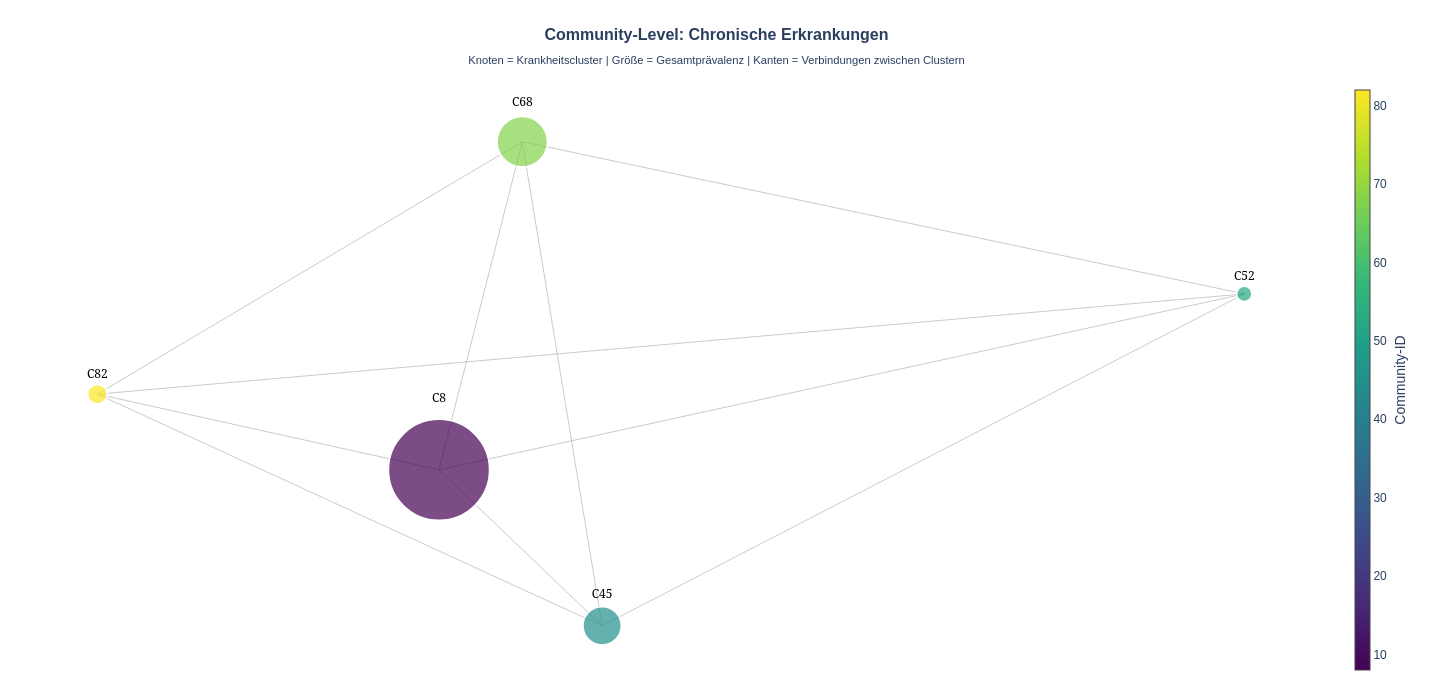


Interpretation:
   • Große Knoten = Communities mit vielen betroffenen Patienten
   • Verbindungen zeigen systemübergreifende Komorbiditäten
   • Hover über Knoten zeigt die wichtigsten Erkrankungen in der Community


In [4]:
# Hole Top 50 Knoten nach Grad (stabiler als PageRank welcher 0 sein könnte)
degrees = dict(G.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]
sub = G.subgraph(top_nodes).copy()

# Nur Knoten mit zugewiesener Community
nodes_with_community = [
    n for n, d in sub.nodes(data=True)
    if 'communityId' in d and d['communityId'] != -1
]
sub_comm = sub.subgraph(nodes_with_community).copy()

print(f"Analysiere {len(nodes_with_community)} Erkrankungen in Communities...")

# Meta-Graph auf Community-Ebene mit erweiterten Informationen
G_comm = nx.Graph()

for n, data in sub_comm.nodes(data=True):
    cid = int(data['communityId'])
    prev = data.get('prevalence', 0)
    name = data.get('name', str(n))

    if cid not in G_comm:
        G_comm.add_node(
            cid,
            total_prevalence=0,
            diseases=0,
            disease_list=[],  # NEU: Liste aller Erkrankungen
            example=name,
            max_prev=0
        )

    G_comm.nodes[cid]['total_prevalence'] += prev
    G_comm.nodes[cid]['diseases'] += 1
    G_comm.nodes[cid]['disease_list'].append((name, prev))  # NEU: Speichere alle

    # Merke dir die "prominenteste" Erkrankung pro Community
    if prev > G_comm.nodes[cid]['max_prev']:
        G_comm.nodes[cid]['max_prev'] = prev
        G_comm.nodes[cid]['example'] = name

# Kanten zwischen Communities: aggregierte Komorbidität
for u, v, edge_data in sub_comm.edges(data=True):
    cu = int(sub_comm.nodes[u]['communityId'])
    cv = int(sub_comm.nodes[v]['communityId'])
    if cu == cv:
        continue  # interne Verbindungen ignorieren

    w = edge_data.get('weight', 1)
    if G_comm.has_edge(cu, cv):
        G_comm[cu][cv]['weight'] += w
    else:
        G_comm.add_edge(cu, cv, weight=w)

print(f"Community-Level-Graph: {G_comm.number_of_nodes()} Communities, "
      f"{G_comm.number_of_edges()} Verbindungen\n")

# NEU: Detaillierte Community-Statistiken ausgeben
print("=" * 80)
print("COMMUNITY-DETAILS:")
print("=" * 80)
for cid in sorted(G_comm.nodes()):
    data = G_comm.nodes[cid]
    print(f"\nCommunity {cid}: {data['diseases']} Erkrankungen, "
          f"{data['total_prevalence']} Patienten gesamt")
    print(f"   Top-Erkrankung: {data['example']} ({data['max_prev']} Patienten)")
    
    # NEU: Zeige alle Erkrankungen in der Community (sortiert nach Prävalenz)
    diseases_sorted = sorted(data['disease_list'], key=lambda x: x[1], reverse=True)
    print(f"   Alle Erkrankungen in dieser Community:")
    for i, (disease_name, disease_prev) in enumerate(diseases_sorted[:5], 1):  # Top 5
        print(f"      {i}. {disease_name} ({disease_prev} Pat.)")
    if len(diseases_sorted) > 5:
        print(f"      ... und {len(diseases_sorted) - 5} weitere")

print("\n" + "=" * 80 + "\n")

# Layout für Community-Graph
pos_comm = nx.spring_layout(G_comm, k=1.2, iterations=200, seed=42)

# Kanten-Trace
edge_x, edge_y = [], []
edge_width = []

for u, v, d in G_comm.edges(data=True):
    x0, y0 = pos_comm[u]
    x1, y1 = pos_comm[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_width.append(0.5 + d['weight'] / 50)

edge_trace_comm = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=1.0, color='rgba(150,150,150,0.5)'),
    hoverinfo='none'
)

# Knoten-Trace mit erweiterten Informationen
node_x, node_y, node_size, node_text, node_color = [], [], [], [], []

for cid, d in G_comm.nodes(data=True):
    x, y = pos_comm[cid]
    node_x.append(x)
    node_y.append(y)

    total_prev = d['total_prevalence']
    diseases = d['diseases']
    example = d['example']
    
    # NEU: Top 3 Erkrankungen für Hover-Text
    diseases_sorted = sorted(d['disease_list'], key=lambda x: x[1], reverse=True)
    top_diseases = diseases_sorted[:3]
    diseases_text = "<br>".join([f"  • {name} ({prev} Pat.)" for name, prev in top_diseases])
    if len(diseases_sorted) > 3:
        diseases_text += f"<br>  • ... und {len(diseases_sorted) - 3} weitere"

    node_size.append(15 + total_prev / 100)
    node_color.append(cid)

    node_text.append(
        f"<b>Community {cid}</b><br>"
        f"<br>"
        f"<b>Statistik:</b><br>"
        f"  Anzahl Erkrankungen: {diseases}<br>"
        f"  Gesamtprävalenz: {total_prev} Patienten<br>"
        f"<br>"
        f"<b>Top-Erkrankungen:</b><br>"
        f"{diseases_text}"
    )

node_trace_comm = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[f"C{cid}" for cid in G_comm.nodes()],
    textposition='top center',
    textfont=dict(size=12, color='black', family='Arial Black'),
    hoverinfo='text',
    hovertext=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        line=dict(width=2, color='white'),
        showscale=True,
        colorbar=dict(
            title=dict(text="Community-ID", side='right'),
            thickness=15
        )
    )
)

fig_comm = go.Figure(
    data=[edge_trace_comm, node_trace_comm],
    layout=go.Layout(
        title=dict(
            text=("<b>Community-Level: Chronische Erkrankungen</b><br>"
                  "<sub>Knoten = Krankheitscluster | "
                  "Größe = Gesamtprävalenz | "
                  "Kanten = Verbindungen zwischen Clustern</sub>"),
            x=0.5,
            xanchor='center',
            font=dict(size=16)
        ),
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        width=1000,
        height=700,
        margin=dict(l=20, r=20, t=80, b=20)
    )
)

fig_comm.show()

print("\nInterpretation:")
print("   • Große Knoten = Communities mit vielen betroffenen Patienten")
print("   • Verbindungen zeigen systemübergreifende Komorbiditäten")
print("   • Hover über Knoten zeigt die wichtigsten Erkrankungen in der Community")

### 3b) Kernnetz – Die stärksten Komorbiditäten

**Was zeigt diese Visualisierung?**
Diese Ansicht fokussiert auf die **stärksten Komorbiditäts-Beziehungen** im Netzwerk. Es werden nur die oberen 25% der Beziehungen nach Gewicht (Anzahl gemeinsamer Patienten) angezeigt.

**Interpretation:**
- **Knoten** = Chronische Erkrankungen mit starken Komorbiditäten
- **Knotengröße** = Prävalenz (Anzahl betroffener Patienten)
- **Farbe** = Community-Zugehörigkeit
- **Kanten** = Nur die stärksten Komorbiditäts-Beziehungen (≥75. Perzentil)
- **Dicke Kanten** = Besonders häufige Komorbidität

**Medizinische Bedeutung:**
Dieses Kernnetz zeigt die **klinisch relevantesten Komorbiditäten**. Erkrankungen, die hier eng verbunden sind, treten überdurchschnittlich häufig gemeinsam auf und sollten bei der Patientenversorgung besonders beachtet werden.

Filter-Schwellwert: Nur Kanten mit weight ≥ 54 (oberes 25%-Perzentil)
   Von 1169 Kanten werden 296 angezeigt

Core-Netzwerk: 50 Knoten, 296 Kanten

TOP 10 STÄRKSTE KOMORBIDITÄTEN:
 1. Gingival disease (disorder)
    ↔ Gingivitis (disorder)
    → 1258 Patienten mit beiden Erkrankungen

 2. Gingivitis (disorder)
    ↔ Body mass index 30+ - obesity (finding)
    → 1227 Patienten mit beiden Erkrankungen

 3. Anemia (disorder)
    ↔ Gingivitis (disorder)
    → 937 Patienten mit beiden Erkrankungen

 4. Gingival disease (disorder)
    ↔ Body mass index 30+ - obesity (finding)
    → 722 Patienten mit beiden Erkrankungen

 5. Anemia (disorder)
    ↔ Body mass index 30+ - obesity (finding)
    → 687 Patienten mit beiden Erkrankungen

 6. Gingivitis (disorder)
    ↔ Essential hypertension (disorder)
    → 614 Patienten mit beiden Erkrankungen

 7. Anemia (disorder)
    ↔ Gingival disease (disorder)
    → 525 Patienten mit beiden Erkrankungen

 8. Essential hypertension (disorder)
    ↔ Body mas

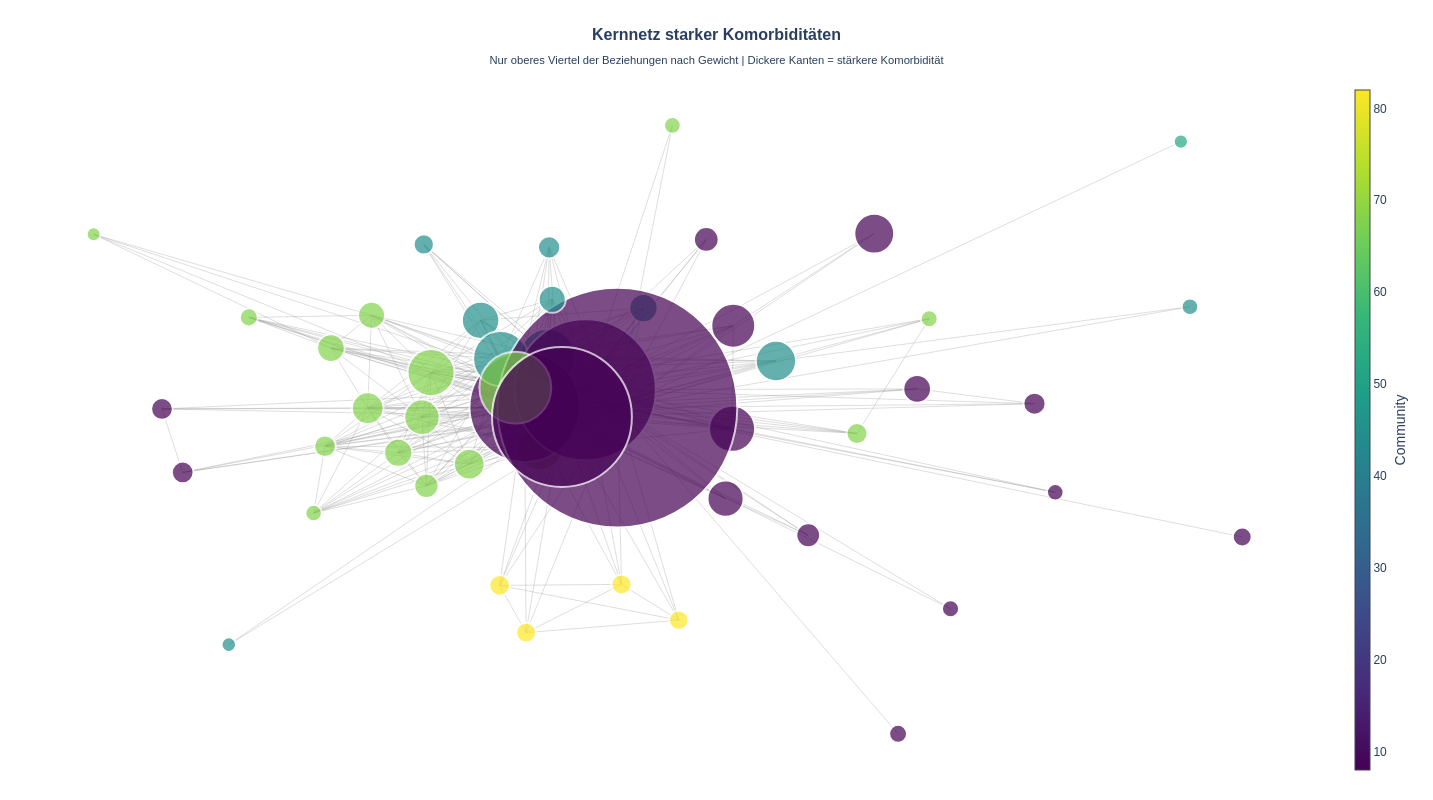


Interpretation:
   • Zentrale Knoten = Erkrankungen mit vielen starken Komorbiditäten
   • Eng verbundene Cluster = häufig gemeinsam auftretende Erkrankungen
   • Dicke Verbindungen = besonders relevante Komorbiditäten für die Versorgung


In [5]:
# Ausgangspunkt: subgraph mit Top-50-Knoten aus Schritt 3
weights = [d.get('weight', 1) for _, _, d in sub.edges(data=True)]

if not weights:
    raise ValueError("Keine Kanten im Subgraph – Prüfe vorherigen Schritt.")

weights_sorted = sorted(weights)
q75_index = int(0.75 * (len(weights_sorted) - 1))
threshold = weights_sorted[q75_index]

print(f"Filter-Schwellwert: Nur Kanten mit weight ≥ {threshold} (oberes 25%-Perzentil)")
print(f"   Von {len(weights)} Kanten werden {len([w for w in weights if w >= threshold])} angezeigt\n")

strong_edges = [
    (u, v) for u, v, d in sub.edges(data=True)
    if d.get('weight', 1) >= threshold
]

core = sub.edge_subgraph(strong_edges).copy()
print(f"Core-Netzwerk: {core.number_of_nodes()} Knoten, {core.number_of_edges()} Kanten\n")

# NEU: Zeige die stärksten Komorbiditäten
print("=" * 80)
print("TOP 10 STÄRKSTE KOMORBIDITÄTEN:")
print("=" * 80)
edge_weights = [
    (core.nodes[u]['name'], core.nodes[v]['name'], d['weight']) 
    for u, v, d in core.edges(data=True)
]
edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)
for i, (disease1, disease2, weight) in enumerate(edge_weights_sorted[:10], 1):
    print(f"{i:2d}. {disease1}")
    print(f"    ↔ {disease2}")
    print(f"    → {int(weight)} Patienten mit beiden Erkrankungen\n")

print("=" * 80 + "\n")

# Layout für das Kernnetz
pos_core = nx.spring_layout(core, k=1.0, iterations=100, seed=42)

# Kanten-Trace mit Gewichtung
edge_x, edge_y, edge_width, edge_text = [], [], [], []
for u, v, d in core.edges(data=True):
    x0, y0 = pos_core[u]
    x1, y1 = pos_core[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    
    w = d.get('weight', 1)
    edge_width.append(0.3 + w / 50)  # Dickere Kanten für stärkere Beziehungen
    edge_text.append(f"{int(w)} Patienten")

edge_trace_core = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(150,150,150,0.4)'),
    hoverinfo='none'
)

# Knoten-Trace mit erweiterten Informationen
node_x, node_y, node_text, node_size, node_color = [], [], [], [], []

for n, data in core.nodes(data=True):
    x, y = pos_core[n]
    node_x.append(x)
    node_y.append(y)

    name       = data.get('name', str(n))
    prevalence = data.get('prevalence', 0)
    pagerank   = data.get('pageRank', 0.0)
    degree     = core.degree(n)
    community  = int(data.get('communityId', 0))
    
    # NEU: Berechne durchschnittliche Komorbidität-Stärke
    neighbors = list(core.neighbors(n))
    if neighbors:
        avg_weight = sum(core[n][nbr]['weight'] for nbr in neighbors) / len(neighbors)
    else:
        avg_weight = 0

    node_text.append(
        f"<b>{name}</b><br>"
        f"<br>"
        f"Prävalenz: {prevalence} Patienten<br>"
        f"Komorbiditäten (im Kernnetz): {degree}<br>"
        f"Ø Komorbidität-Stärke: {avg_weight:.1f} Patienten<br>"
        f"PageRank: {pagerank:.4f}<br>"
        f"Community: {community}"
    )

    node_size.append(8 + prevalence / 10)
    node_color.append(community)

node_trace_core = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        line=dict(width=2, color='white'),
        showscale=True,
        colorbar=dict(
            title=dict(text='Community', side='right'),
            thickness=15
        )
    )
)

fig_core = go.Figure(
    data=[edge_trace_core, node_trace_core],
    layout=go.Layout(
        title=dict(
            text=("<b>Kernnetz starker Komorbiditäten</b><br>"
                  "<sub>Nur oberes Viertel der Beziehungen nach Gewicht | "
                  "Dickere Kanten = stärkere Komorbidität</sub>"),
            x=0.5,
            xanchor='center',
            font=dict(size=16)
        ),
        showlegend=False,
        hovermode='closest',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        width=1000,
        height=800,
        margin=dict(l=20, r=20, t=80, b=20)
    )
)

fig_core.show()

print("\nInterpretation:")
print("   • Zentrale Knoten = Erkrankungen mit vielen starken Komorbiditäten")
print("   • Eng verbundene Cluster = häufig gemeinsam auftretende Erkrankungen")
print("   • Dicke Verbindungen = besonders relevante Komorbiditäten für die Versorgung")

## Schritt 4: Metabolisches Syndrom - Subgraph-Analyse

**Was ist ein Subgraph?** Ein Teilnetzwerk, das nur bestimmte Erkrankungen und ihre direkten Nachbarn zeigt. Hier: Metabolisches Syndrom (Übergewicht, Diabetes, Bluthochdruck, Herz-Kreislauf-Erkrankungen).

**Warum diese Analyse?** Das metabolische Syndrom ist eine der häufigsten und gefährlichsten Krankheitskombinationen. Diese Visualisierung zeigt, wie diese Erkrankungen miteinander vernetzt sind und welche anderen Erkrankungen häufig damit auftreten.


METABOLISCHES SYNDROM - CLUSTER
   Kern-Erkrankungen: 16
   Erweitertes Netzwerk: 145 Erkrankungen
   Kanten: 3251
Nutze nur Kanten mit weight ≥ 18.00 (oberes 25%-Perzentil)
Kernnetz: 102 Knoten, 839 Kanten


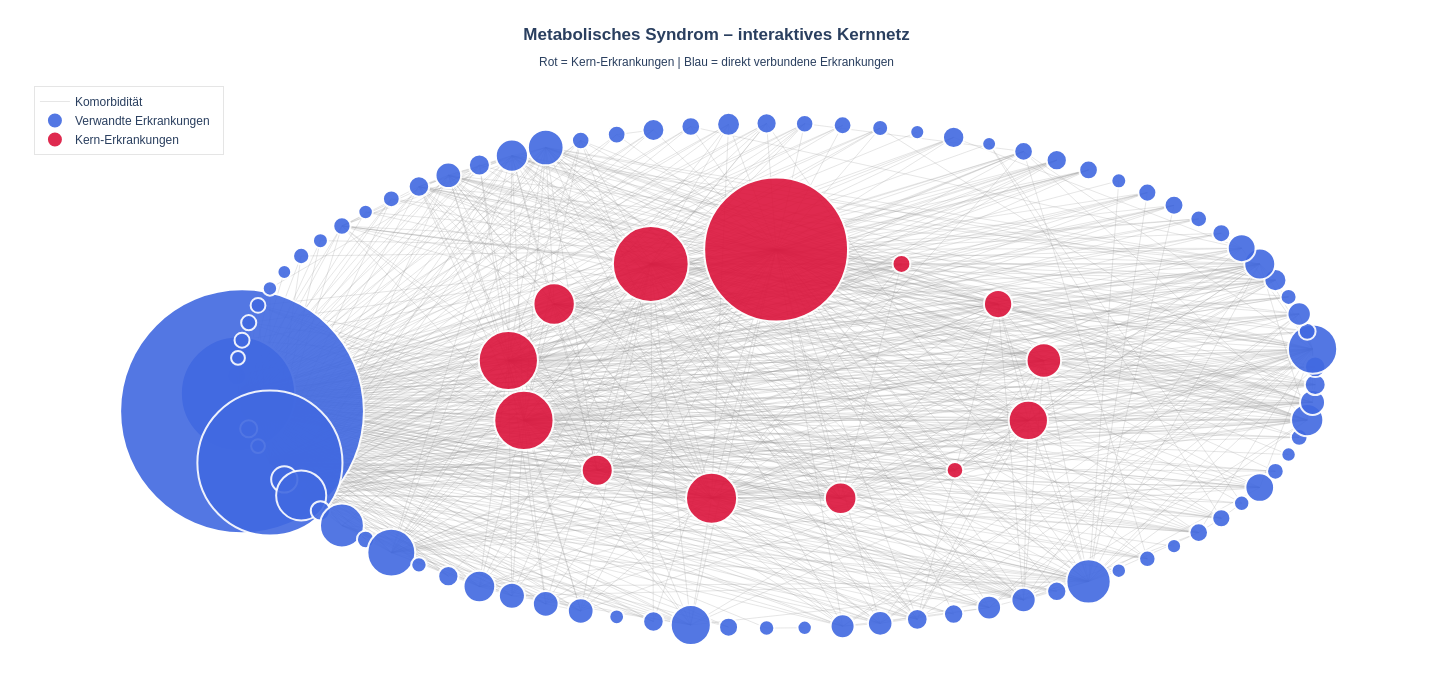


Interaktive Ansicht:
   • Maus über einen Knoten bewegen → Name + Prävalenz + PageRank + Degree + Community
   • Rot = Kern-Erkrankungen (z.B. Adipositas, Diabetes, Hypertonie)
   • Blau = wichtige, direkt verbundene Komorbiditäten


In [6]:
# Finde metabolisches Syndrom relevante Erkrankungen
metabolic_keywords = ['obesity', 'diabetes', 'prediabetes', 'hypertension', 'metabolic', 
                     'cardiovascular', 'coronary', 'ischemic', 'hyperlipidemia']

metabolic_nodes = [node for node in G.nodes() 
                  if any(keyword in G.nodes[node]['name'].lower() 
                        for keyword in metabolic_keywords)]

# Füge Nachbarn hinzu (1-Hop entfernt)
metabolic_extended = set(metabolic_nodes)
for node in metabolic_nodes:
    metabolic_extended.update(G.neighbors(node))

metabolic_subgraph = G.subgraph(metabolic_extended).copy()

print(f"\nMETABOLISCHES SYNDROM - CLUSTER")
print(f"   Kern-Erkrankungen: {len(metabolic_nodes)}")
print(f"   Erweitertes Netzwerk: {len(metabolic_extended)} Erkrankungen")
print(f"   Kanten: {metabolic_subgraph.number_of_edges()}")

# Visualisiere mit besserem Layout und Farben
if metabolic_subgraph.number_of_nodes() == 0:
    raise ValueError("metabolic_subgraph ist leer – bitte Schritt 4 prüfen.")

# 1) Nur starke Kanten behalten (oberes 25%-Perzentil nach 'weight')
weights = [d.get('weight', 1) for _, _, d in metabolic_subgraph.edges(data=True)]

if len(weights) == 0:
    # Fallback: wenn keine weights hinterlegt sind, nimm kompletten Subgraph
    print("⚠️ Keine 'weight'-Attribute gefunden – verwende vollständigen Subgraph.")
    metabolic_core = metabolic_subgraph.copy()
else:
    q75 = np.percentile(weights, 75)
    print(f"Nutze nur Kanten mit weight ≥ {q75:.2f} (oberes 25%-Perzentil)")

    strong_edges = [
        (u, v) for u, v, d in metabolic_subgraph.edges(data=True)
        if d.get('weight', 1) >= q75
    ]
    metabolic_core = metabolic_subgraph.edge_subgraph(strong_edges).copy()
    metabolic_core.remove_nodes_from(list(nx.isolates(metabolic_core)))

print(f"Kernnetz: {metabolic_core.number_of_nodes()} Knoten, "
      f"{metabolic_core.number_of_edges()} Kanten")

if metabolic_core.number_of_nodes() == 0:
    raise ValueError("Nach Filterung ist kein Kernnetz übrig – q75 ggf. reduzieren.")

# 2) Shell-Layout: Innen = Kern-Erkrankungen, außen = Nachbarn
core_nodes  = [n for n in metabolic_core.nodes() if n in metabolic_nodes]
other_nodes = [n for n in metabolic_core.nodes() if n not in metabolic_nodes]

# Fallback: falls durch Filterung kein Kernknoten übrig bleibt
if not core_nodes:
    print("⚠️ Keine Kern-Knoten im gefilterten Graph – verwende alle als Kern.")
    core_nodes  = list(metabolic_core.nodes())
    other_nodes = []

nlist = [core_nodes]
if other_nodes:
    nlist.append(other_nodes)

pos = nx.shell_layout(metabolic_core, nlist=nlist)

# 3) Kanten-Trace (als eine Scatter-Linie)
edge_x, edge_y = [], []
for u, v, d in metabolic_core.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.6, color='rgba(150,150,150,0.4)'),
    hoverinfo='none',
    name='Komorbidität'
)

# 4) Node-Traces: Kern-Erkrankungen (rot) und Nachbarn (blau), mit Hover-Text

def build_node_trace(nodes, color, name):
    node_x, node_y, node_size, node_text = [], [], [], []

    for n in nodes:
        x, y = pos[n]
        node_x.append(x)
        node_y.append(y)

        data = metabolic_core.nodes[n]
        disease_name = data.get('name', str(n))
        prevalence   = data.get('prevalence', 0)
        pagerank     = data.get('pageRank', 0.0)
        community    = data.get('communityId', 'n/a')
        degree       = metabolic_core.degree(n)

        # Tooltip-Text (wird beim Hover angezeigt)
        node_text.append(
            f"<b>{disease_name}</b><br>"
            f"Prävalenz: {prevalence} Patienten<br>"
            f"PageRank: {pagerank:.4f}<br>"
            f"Komorbiditäten im Kernnetz: {degree}<br>"
            f"Community: {community}"
        )

        # Knotengröße nach Prävalenz skalieren (leichte Skalierung, damit es nicht explodiert)
        node_size.append(12 + prevalence / 10)

    return go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers',
        name=name,
        hoverinfo='text',
        text=node_text,
        marker=dict(
            size=node_size,
            color=color,
            line=dict(width=2, color='white'),
            opacity=0.9
        )
    )

core_trace  = build_node_trace(core_nodes,  'crimson',   'Kern-Erkrankungen')
other_trace = build_node_trace(other_nodes, 'royalblue', 'Verwandte Erkrankungen')

# 5) Figure zusammenbauen
fig_metabolic = go.Figure(
    data=[edge_trace, other_trace, core_trace],
    layout=go.Layout(
        title=dict(
            text=(
                "<b>Metabolisches Syndrom – interaktives Kernnetz</b><br>"
                "<sub>Rot = Kern-Erkrankungen | Blau = direkt verbundene Erkrankungen</sub>"
            ),
            x=0.5,
            xanchor='center'
        ),
        showlegend=True,
        legend=dict(
            x=0.01, y=0.99,
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.1)',
            borderwidth=1
        ),
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=80),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        width=900,
        height=700
    )
)

fig_metabolic.show()

print("\nInteraktive Ansicht:")
print("   • Maus über einen Knoten bewegen → Name + Prävalenz + PageRank + Degree + Community")
print("   • Rot = Kern-Erkrankungen (z.B. Adipositas, Diabetes, Hypertonie)")
print("   • Blau = wichtige, direkt verbundene Komorbiditäten")

## Schritt 5: Top 10 Kürzeste Pfade zwischen Schlüssel-Erkrankungen

**Was ist ein kürzester Pfad?** Die direkteste Verbindung zwischen zwei Erkrankungen über gemeinsame Komorbiditäten. Zeigt, über welche "Brücken-Erkrankungen" Patienten von einer Erkrankung zur anderen gelangen können.

**Medizinische Bedeutung:** Kürzeste Pfade zwischen häufigen Erkrankungen zeigen wichtige klinische Zusammenhänge. Ein kurzer Pfad (z.B. 1-2 Schritte) bedeutet eine starke Verbindung, ein langer Pfad (5+ Schritte) eine schwächere. Die Analyse hilft, Risikoketten zu verstehen.

**Diese Analyse:** Wir finden die 10 kürzesten Pfade zwischen den häufigsten Erkrankungen (Top 20 nach Prävalenz) und visualisieren sie mit Kontext.


Top 20 Erkrankungen nach Prävalenz:
    1. Gingivitis (disorder)                              (2318 Patienten)
    2. Gingival disease (disorder)                        (1331 Patienten)
    3. Body mass index 30+ - obesity (finding)            (1319 Patienten)
    4. Anemia (disorder)                                  (1023 Patienten)
    5. Essential hypertension (disorder)                  ( 638 Patienten)
    6. Abnormal findings diagnostic imaging heart+coronar ( 473 Patienten)
    7. Ischemic heart disease (disorder)                  ( 472 Patienten)
    8. Metabolic syndrome X (disorder)                    ( 391 Patienten)
    9. Laceration - injury (disorder)                     ( 381 Patienten)
   10. Loss of teeth (disorder)                           ( 373 Patienten)
   ... (Top 11-20 nicht angezeigt)

Berechne kürzeste Pfade zwischen Top-20-Erkrankungen...

Interaktive Visualisierung der Top 5 kürzesten Pfade...



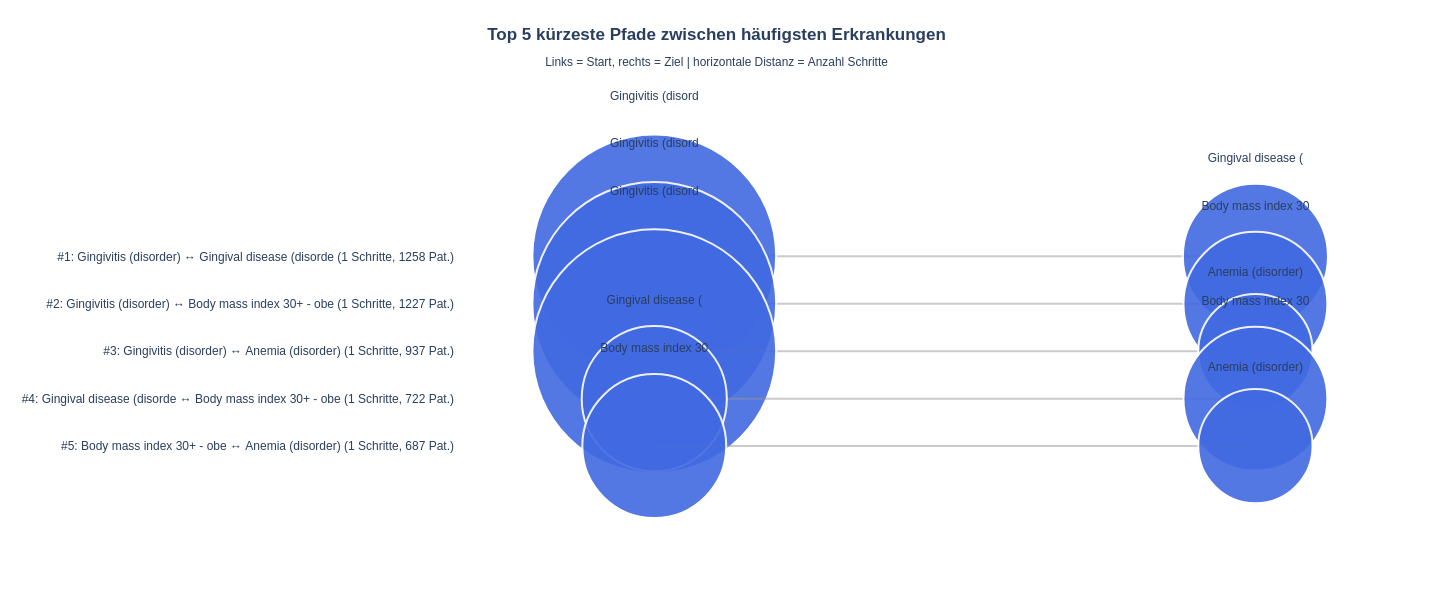

ℹHinweis:
   • Jede horizontale Zeile ist ein Pfad zwischen zwei häufigen Erkrankungen.
   • Knoten-Größe ~ Prävalenz, bei Hover: Details zur jeweiligen Erkrankung.
   • Je mehr Zwischenknoten, desto länger die 'Risikokette'.


In [7]:
# Finde Top 20 Erkrankungen nach Prävalenz
top_diseases = sorted(G.nodes(), key=lambda x: G.nodes[x]['prevalence'], reverse=True)[:20]

print("\nTop 20 Erkrankungen nach Prävalenz:")
for i, node in enumerate(top_diseases[:10], 1):
    name = G.nodes[node]['name']
    prev = G.nodes[node]['prevalence']
    print(f"   {i:2d}. {name[:50]:50s} ({prev:4d} Patienten)")
print("   ... (Top 11-20 nicht angezeigt)")

# Berechne kürzeste Pfade zwischen allen Top-20-Paaren
print("\nBerechne kürzeste Pfade zwischen Top-20-Erkrankungen...")
shortest_paths = []

for i, source in enumerate(top_diseases):
    for target in top_diseases[i+1:]:  # Vermeide Duplikate
        try:
            path = nx.shortest_path(G, source, target)
            path_length = len(path) - 1
            
            # Berechne Gesamtgewicht des Pfades (Summe der Kantengewichte)
            total_weight = sum(G[path[j]][path[j+1]]['weight'] for j in range(len(path)-1))
            
            shortest_paths.append({
                'source': source,
                'target': target,
                'path': path,
                'length': path_length,
                'total_weight': total_weight
            })
        except nx.NetworkXNoPath:
            continue  # Kein Pfad vorhanden

# Sortiere nach Pfadlänge (kürzeste zuerst), dann nach Gewicht (stärkste zuerst)
shortest_paths.sort(key=lambda x: (x['length'], -x['total_weight']))

# Zeige Top 10 kürzeste Pfade
top_10_paths = shortest_paths[:10]

if "top_10_paths" not in globals():
    raise RuntimeError("⚠️ Variable 'top_10_paths' nicht gefunden – bitte zuerst Schritt 5 ausführen.")

top_paths = top_10_paths[:5]

print("\nInteraktive Visualisierung der Top 5 kürzesten Pfade...\n")

fig = go.Figure()

y_vals = []
y_labels = []

for idx, path_info in enumerate(top_paths):
    path = path_info["path"]
    length = path_info["length"]
    total_weight = path_info["total_weight"]
    
    source_name = G.nodes[path_info["source"]]["name"]
    target_name = G.nodes[path_info["target"]]["name"]
    
    # Eine Zeile pro Pfad (Lane)
    y = -idx  # einfach unterschiedliche Y-Werte
    y_vals.append(y)
    y_labels.append(
        f"#{idx+1}: {source_name[:25]} ↔ {target_name[:25]} "
        f"({length} Schritte, {total_weight:.0f} Pat.)"
    )
    
    # Positionen der Knoten entlang der X-Achse
    xs = list(range(len(path)))
    ys = [y] * len(path)
    
    # Kanten (zwischen aufeinanderfolgenden Knoten)
    edge_x, edge_y = [], []
    for j in range(len(path) - 1):
        edge_x += [xs[j], xs[j+1], None]
        edge_y += [ys[j], ys[j+1], None]
    
    fig.add_trace(go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=2, color="rgba(150,150,150,0.5)"),
        hoverinfo="none",
        showlegend=False
    ))
    
    # Knoten mit Hover-Infos
    node_x, node_y, node_text, node_hover, node_size = [], [], [], [], []
    
    for j, n in enumerate(path):
        data = G.nodes[n]
        name       = data.get("name", str(n))
        prevalence = data.get("prevalence", 0)
        pagerank   = data.get("pageRank", 0.0)
        community  = data.get("communityId", "n/a")
        degree     = G.degree(n)
        
        node_x.append(xs[j])
        node_y.append(ys[j])
        node_text.append(name[:18])  # kurzer Label im Plot
        
        node_hover.append(
            f"<b>{name}</b><br>"
            f"Prävalenz: {prevalence} Patienten<br>"
            f"PageRank: {pagerank:.4f}<br>"
            f"Komorbiditäten (Grad): {degree}<br>"
            f"Community: {community}"
        )
        
        node_size.append(12 + prevalence / 10)  # sanfte Skalierung
    
    fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=node_text,
        textposition="top center",
        hovertext=node_hover,
        hoverinfo="text",
        marker=dict(
            size=node_size,
            color="royalblue",
            line=dict(width=2, color="white"),
            opacity=0.9
        ),
        showlegend=False
    ))

# Layout anpassen
fig.update_layout(
    title=dict(
        text=(
            "<b>Top 5 kürzeste Pfade zwischen häufigsten Erkrankungen</b><br>"
            "<sub>Links = Start, rechts = Ziel | horizontale Distanz = Anzahl Schritte</sub>"
        ),
        x=0.5,
        xanchor="center"
    ),
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        tickmode="array",
        tickvals=y_vals,
        ticktext=y_labels
    ),
    plot_bgcolor="white",
    width=1100,
    height=600,
    margin=dict(l=220, r=40, t=80, b=40),  # Platz links für die Pfad-Beschriftung
)

fig.show()

print("ℹHinweis:")
print("   • Jede horizontale Zeile ist ein Pfad zwischen zwei häufigen Erkrankungen.")
print("   • Knoten-Größe ~ Prävalenz, bei Hover: Details zur jeweiligen Erkrankung.")
print("   • Je mehr Zwischenknoten, desto länger die 'Risikokette'.")

## Schritt 6: Visualisierung der Community-Struktur

**Was sind Communities?** Gruppen von Erkrankungen, die häufig zusammen auftreten und untereinander stärker vernetzt sind als mit anderen Gruppen. Diese wurden mit dem Louvain-Algorithmus identifiziert.

**Medizinische Bedeutung:** Communities zeigen typische Krankheitsmuster. Z.B. eine "kardiovaskuläre Community" (Herz-Kreislauf-Erkrankungen) oder eine "metabolische Community" (Stoffwechsel-Erkrankungen). Dies hilft, Risikoprofile zu verstehen und gezielte Präventionsmaßnahmen zu entwickeln.


TOP 5 ERKRANKUNGS-COMMUNITIES (von 23 insgesamt)

Community 8: 83 Erkrankungen
  - Gingivitis (disorder)
  - Gingival disease (disorder)
  - Body mass index 30+ - obesity (finding)

Community 68: 35 Erkrankungen
  - Essential hypertension (disorder)
  - Metabolic syndrome X (disorder)
  - Loss of teeth (disorder)

Community 45: 31 Erkrankungen
  - Abnormal findings diagnostic imaging heart+coronar
  - Ischemic heart disease (disorder)
  - Fracture of bone (disorder)

Community 52: 7 Erkrankungen
  - Pneumonia (disorder)
  - Hypoxemia (disorder)
  - Acute respiratory failure (disorder)

Community 82: 4 Erkrankungen
  - Dependent drug abuse (disorder)
  - Impacted molars (disorder)
  - Overdose (disorder)



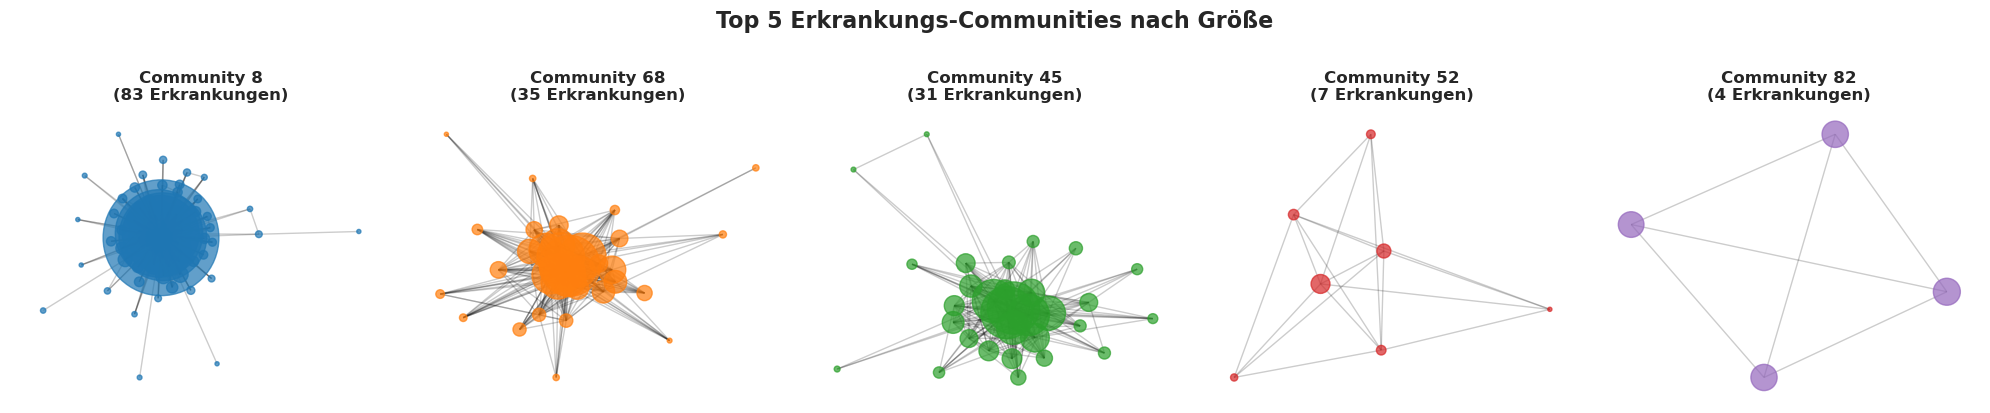

In [8]:
# Sammle Communities
communities = {}
for node in G.nodes():
    comm_id = G.nodes[node]['communityId']
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Top 5 Communities nach Größe
top_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)[:5]

print(f"\nTOP 5 ERKRANKUNGS-COMMUNITIES (von {len(communities)} insgesamt)\n")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (comm_id, nodes) in enumerate(top_communities):
    subgraph = G.subgraph(nodes).copy()
    
    print(f"Community {comm_id}: {len(nodes)} Erkrankungen")
    
    # Zeige Top 3 Erkrankungen
    top_3 = sorted(nodes, key=lambda x: G.nodes[x]['prevalence'], reverse=True)[:3]
    for node in top_3:
        print(f"  - {G.nodes[node]['name'][:50]}")
    print()
    
    # Visualisiere
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, k=0.5, seed=42)
    
    node_sizes = [subgraph.nodes[node]['prevalence'] * 3 for node in subgraph.nodes()]
    
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2, ax=ax)
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, 
                          node_color=f'C{idx}', alpha=0.7, ax=ax)
    
    ax.set_title(f'Community {comm_id}\n({len(nodes)} Erkrankungen)', fontweight='bold')
    ax.axis('off')

plt.suptitle('Top 5 Erkrankungs-Communities nach Größe', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Schritt 7: Vergleich von Zentralitätsmaßen

**Was sind Zentralitätsmaße?** Verschiedene Methoden, um wichtige Knoten im Netzwerk zu identifizieren:
- **Degree Centrality**: Anzahl direkter Verbindungen (wie viele Komorbiditäten)
- **Closeness Centrality**: Wie "nah" eine Erkrankung an allen anderen ist (schnelle Erreichbarkeit)
- **Eigenvector Centrality**: Verbindungen zu wichtigen Knoten zählen mehr
- **PageRank**: Wie wichtig sind die Nachbarn (Google-Algorithmus)

**Medizinische Interpretation:** Erkrankungen mit hoher Zentralität sind "Schlüsselerkrankungen" - sie haben großen Einfluss auf das Gesamtnetzwerk und sollten in Präventionsstrategien priorisiert werden.


TOP 10 ERKRANKUNGEN - ZENTRALITÄTSVERGLEICH

                              Erkrankung Degree Closeness Eigenvector PageRank
                   Gingivitis (disorder) 0.8870    0.8871      0.1532  14.2561
             Gingival disease (disorder) 0.8136    0.8162      0.1518   8.9608
                       Anemia (disorder) 0.7966    0.8070      0.1506   7.5112
 Body mass index 30+ - obesity (finding) 0.7910    0.7979      0.1502   9.3527
       Essential hypertension (disorder) 0.7232    0.7478      0.1477   5.9116
       Ischemic heart disease (disorder) 0.6497    0.6967      0.1436   4.6886
Abnormal findings diagnostic imaging hea 0.6497    0.6967      0.1436   4.7021
                Loss of teeth (disorder) 0.6158    0.6769      0.1414   3.4182
         Metabolic syndrome X (disorder) 0.6102    0.6737      0.1414   4.1996
Disorder of kidney due to diabetes melli 0.6045    0.6706      0.1408   3.4392


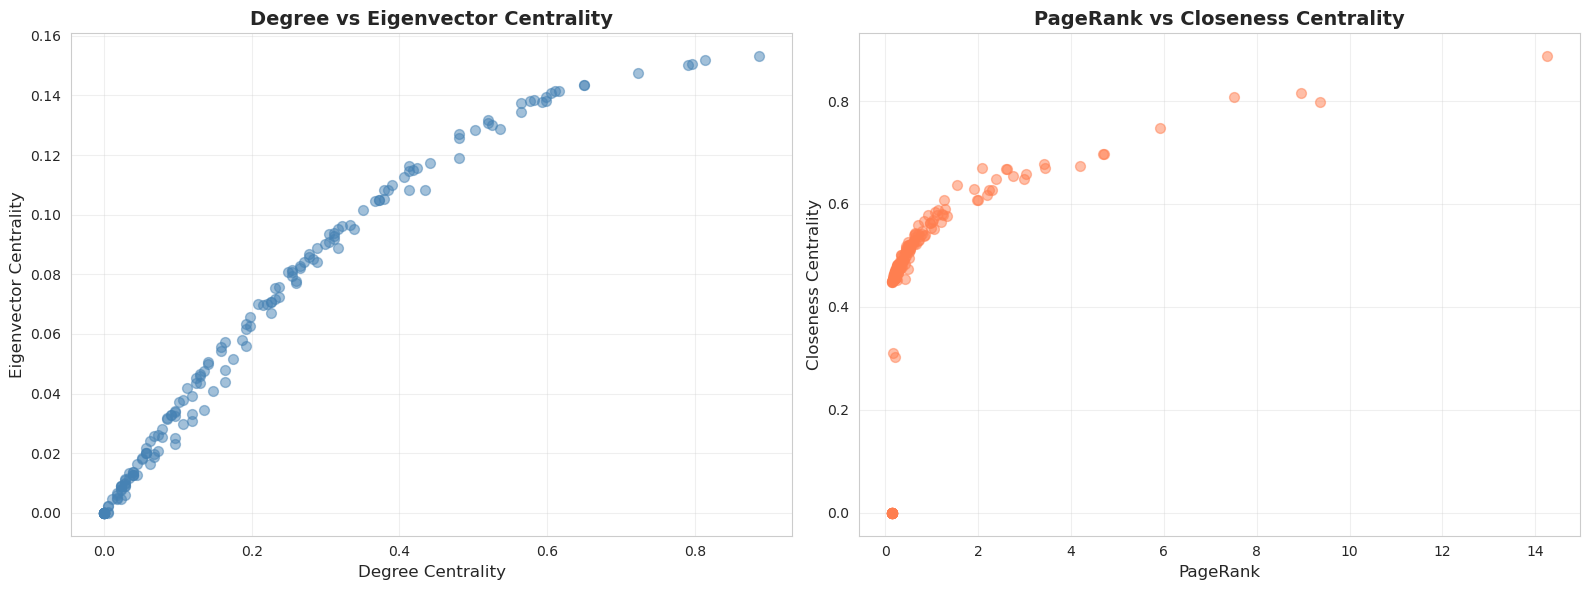

In [9]:
# Berechne Zentralitätsmaße
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Hole Top 20 nach jedem Maß
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

# Erstelle DataFrame für Vergleich
comparison_data = []
for node, _ in top_degree[:10]:
    comparison_data.append({
        'Erkrankung': G.nodes[node]['name'][:40],
        'Degree': f"{degree_centrality[node]:.4f}",
        'Closeness': f"{closeness_centrality[node]:.4f}",
        'Eigenvector': f"{eigenvector_centrality[node]:.4f}",
        'PageRank': f"{G.nodes[node]['pageRank']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTOP 10 ERKRANKUNGEN - ZENTRALITÄTSVERGLEICH\n")
print(comparison_df.to_string(index=False))

# Streudiagramm: Degree vs Eigenvector
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

degree_vals = [degree_centrality[node] for node in G.nodes()]
eigen_vals = [eigenvector_centrality[node] for node in G.nodes()]
close_vals = [closeness_centrality[node] for node in G.nodes()]
pagerank_vals = [G.nodes[node]['pageRank'] for node in G.nodes()]

ax1.scatter(degree_vals, eigen_vals, alpha=0.5, s=50, c='steelblue')
ax1.set_xlabel('Degree Centrality', fontsize=12)
ax1.set_ylabel('Eigenvector Centrality', fontsize=12)
ax1.set_title('Degree vs Eigenvector Centrality', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.scatter(pagerank_vals, close_vals, alpha=0.5, s=50, c='coral')
ax2.set_xlabel('PageRank', fontsize=12)
ax2.set_ylabel('Closeness Centrality', fontsize=12)
ax2.set_title('PageRank vs Closeness Centrality', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Schritt 8: Export für Gephi (Optional)

**Was ist Gephi?** Eine professionelle Open-Source-Software für Netzwerk-Visualisierung. Das GEXF-Format ermöglicht den Export unseres Graphen für erweiterte Visualisierungen außerhalb von Python.

**Warum exportieren?** Gephi bietet mehr Layoutoptionen, bessere Performance bei großen Netzwerken und zusätzliche Analysefunktionen. Ideal für publikationsreife Grafiken.

In [10]:
# Export nach GEXF
output_file = '/home/jovyan/work/comorbidity_network.gexf'

# Erstelle Kopie mit String-Attributen (GEXF Anforderung)
G_export = G.copy()
for node in G_export.nodes():
    G_export.nodes[node]['label'] = G_export.nodes[node]['name']
    G_export.nodes[node]['prevalence'] = float(G_export.nodes[node]['prevalence'])
    G_export.nodes[node]['pageRank'] = float(G_export.nodes[node]['pageRank'])
    G_export.nodes[node]['betweenness'] = float(G_export.nodes[node]['betweenness'])
    G_export.nodes[node]['communityId'] = int(G_export.nodes[node]['communityId'])

nx.write_gexf(G_export, output_file)
print(f"\nGraph exportiert nach: {output_file}")
print("   Sie können diese Datei in Gephi für erweiterte Visualisierung öffnen")
print("   https://gephi.org/")


Graph exportiert nach: /home/jovyan/work/comorbidity_network.gexf
   Sie können diese Datei in Gephi für erweiterte Visualisierung öffnen
   https://gephi.org/


## Zusammenfassende Statistiken

Übersicht aller wichtigen Netzwerk-Metriken aus dieser Analyse.

In [11]:
print("\n" + "="*60)
print("ABSCHLIESSENDE NETZWERK-ANALYSE ZUSAMMENFASSUNG")
print("="*60)
print(f"Knoten (Erkrankungen):              {G.number_of_nodes():,}")
print(f"Kanten (Komorbiditäten):            {G.number_of_edges():,}")
print(f"Netzwerk-Dichte:                    {nx.density(G):.4f}")
print(f"Durchschnittlicher Grad:            {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Durchschnittliches Clustering:      {nx.average_clustering(G):.4f}")
print(f"Erkannte Communities:               {len(set(nx.get_node_attributes(G, 'communityId').values()))}")

if nx.is_connected(G):
    print(f"Netzwerk-Durchmesser:               {nx.diameter(G)}")
    print(f"Durchschnittliche kürzeste Pfadlänge: {nx.average_shortest_path_length(G):.2f}")
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_cc = G.subgraph(largest_cc).copy()
    print(f"Größte Komponente:                  {len(largest_cc)} ({100*len(largest_cc)/G.number_of_nodes():.1f}%)")
    print(f"Durchmesser (größte Komponente):    {nx.diameter(G_cc)}")
    print(f"Ø Pfad (größte Komponente):         {nx.average_shortest_path_length(G_cc):.2f}")

print("="*60)
print("\n✅ Erweiterte Netzwerk-Analyse abgeschlossen!")


ABSCHLIESSENDE NETZWERK-ANALYSE ZUSAMMENFASSUNG
Knoten (Erkrankungen):              178
Kanten (Komorbiditäten):            3,358
Netzwerk-Dichte:                    0.2132
Durchschnittlicher Grad:            37.73
Durchschnittliches Clustering:      0.7336
Erkannte Communities:               23
Größte Komponente:                  160 (89.9%)
Durchmesser (größte Komponente):    4
Ø Pfad (größte Komponente):         1.76

✅ Erweiterte Netzwerk-Analyse abgeschlossen!


## Aufräumen

Schließe die Datenbankverbindung.

In [12]:
driver.close()
print("✅ Verbindung geschlossen")

✅ Verbindung geschlossen
